### Experiments setup

In [1]:
from sksurv.ensemble import RandomSurvivalForest
from pycox import datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter
from matplotlib.colors import ListedColormap

import warnings
warnings.filterwarnings('ignore')

In [2]:
# read text file into pandas DataFrame
data = pd.read_csv("BRCA_data_clinical_RNASeq_n_genes_20501.csv")

In [3]:
data.head()

,patientID,years_to_birth,vital_status,days_to_death,days_to_last_followup,tumor_tissue_site,pathologic_stage,gender,date_of_initial_pathologic_diagnosis,days_to_last_known_alive,...,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,psiTPTE22,tAKR
0,TCGA-A1-A0SB,70.0,0,NaN,259.0,breast,stage 1,female,2008.0,NaN,...,2.287133,3.127326,3.628122,1.507071,3.609663,4.365162,3.783233,3.635225,3.157963,0.000000
1,TCGA-A1-A0SD,59.0,0,NaN,437.0,breast,stage 2,female,2005.0,NaN,...,2.288745,3.180894,3.556044,1.764392,3.383720,4.088852,3.577295,3.543620,2.233037,0.000000
2,TCGA-A1-A0SE,56.0,0,NaN,1321.0,breast,stage 1,female,2005.0,NaN,...,2.284429,3.294886,3.463701,2.035278,3.434295,4.004651,3.416175,3.490708,3.382603,0.000000
3,TCGA-A1-A0SF,54.0,0,NaN,1463.0,breast,stage 2,female,2006.0,NaN,...,2.159502,3.140537,3.480385,2.280490,3.391224,4.291910,3.420459,3.116309,1.987642,0.309427
4,TCGA-A1-A0SG,61.0,0,NaN,434.0,breast,stage 2,female,2006.0,NaN,...,1.955616,3.028257,3.504511,0.445999,3.278195,3.989777,3.717984,3.173279,1.639709,0.000000


In [13]:
# First 13 features are selected as non-expression gene features
fixed_fnames = data.columns.values[:13]
# Check the level of missing data of non-expression gene features
np.sum(data[fixed_fnames].isna())

patientID                                  0
years_to_birth                            15
vital_status                               0
days_to_death                            942
days_to_last_followup                    152
tumor_tissue_site                          0
pathologic_stage                           8
gender                                     0
date_of_initial_pathologic_diagnosis       2
days_to_last_known_alive                1091
radiation_therapy                         95
number_of_lymph_nodes                    168
race                                      95
dtype: int64

In [15]:
# Remove irrelevant in fixed feature
n_samples = data.shape[0]
data["surv_time"] = [data.days_to_death.values[idx] if data.vital_status[idx] else data.days_to_last_followup.values[idx] for idx in range(n_samples)]
droped_fixed_fnames = ["patientID", "days_to_death", "days_to_last_followup", 
                       "days_to_last_known_alive", "date_of_initial_pathologic_diagnosis"]
data = data.rename(columns={"vital_status": "surv_indicator"})
data = data.drop(columns=droped_fixed_fnames).dropna()

kept_fixed_fnames = [fname for fname in fixed_fnames if fname not in droped_fixed_fnames + ["vital_status"]]

In [17]:
# Extract dataset
feat_cols = np.array([col for col in data.columns.values if col not in ["surv_time", "surv_indicator"]])
feats = data[feat_cols]
surv_label = data[["surv_time", "surv_indicator"]].values
surv_times, surv_inds = surv_label[:, 0], surv_label[:, 1]
surv_label_df = pd.DataFrame(surv_label, columns=['surv_time', 'surv_indicator'])

### Survival label Analysis

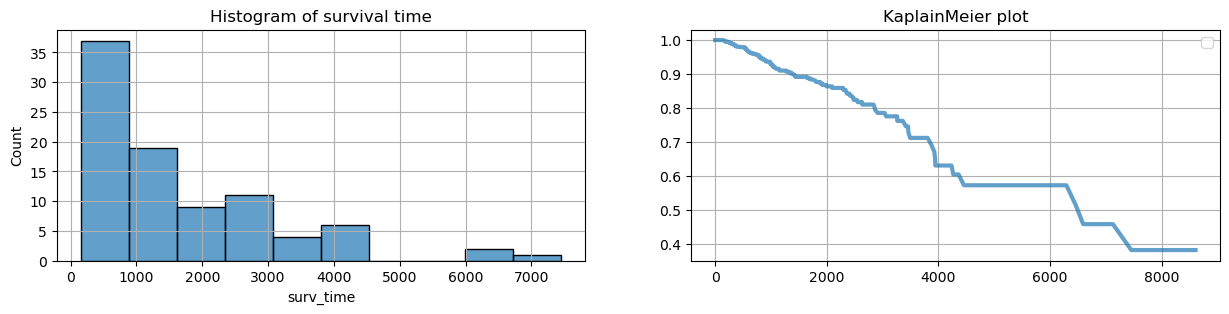

In [20]:
_, ax = plt.subplots(1, 2, figsize=(15, 3))

# Plot the hist plot
sns.histplot(data=surv_label_df[surv_label_df.surv_indicator == 1], x = 'surv_time', ax=ax[0], alpha=0.7)
ax[0].grid()
ax[0].set_title("Histogram of survival time")

# Plot the KaplainMeier plot
ax[1].grid()
ax[1].set_title("KaplainMeier plot")

kmf = KaplanMeierFitter()
kmf.fit(surv_times, surv_inds, label='kmf')
time = kmf.survival_function_.index.values
mean = kmf.survival_function_['kmf'].values
ax[1].plot(time, mean, linewidth=3, alpha=0.7)
ax[1].legend()
plt.show()

In [22]:
print("Censoring percentage {:.2f} %".format(100 * (1 - (sum(surv_inds) / len(surv_inds)))))

Censoring percentage 89.40 %


### Feature Analysis

In [25]:
feats.info()

<class 'pandas.core.frame.DataFrame'>
Index: 840 entries, 14 to 1091
Columns: 20508 entries, years_to_birth to tAKR
dtypes: float64(20221), int64(282), object(5)
memory usage: 131.4+ MB


***Feature preprocessing***

In [28]:
# Split numerical and categorical features
numeric_feat_cols = feats.select_dtypes(include=[np.dtype('int64'), np.dtype('float64')]).columns.tolist()
cate_feat_cols = [col for col in feat_cols if col not in numeric_feat_cols]

In [30]:
# Remove categorical features whose values is constant
cate_feat_cols_keep = []
for fname in cate_feat_cols:
    if len(np.unique(feats[fname].values)) > 1:
        cate_feat_cols_keep.append(fname)
cate_feat_cols = cate_feat_cols_keep

# Remove numerical features whose values is constant
var_df = pd.DataFrame(feats[numeric_feat_cols].var().T, columns=['value'])
numeric_feat_cols_keep = var_df[var_df.value > 0].index.values.tolist()
numeric_feat_cols = numeric_feat_cols_keep
feat_cols = [col for col in feat_cols if col in numeric_feat_cols + cate_feat_cols]
feats = feats[feat_cols]

In [36]:
print("Number of remaining features after removing constant values features is {}".format(feats.shape[1]))

Number of remaining features after removing constant values features is 20204


***Feature pre-screening***

In [39]:
# Survival model to be explained
surv_label_structarray = []
for i in range(surv_label.shape[0]):
    surv_label_structarray.append((bool(surv_label[i, 1]), surv_label[i, 0]))

surv_label_structarray = np.rec.array(surv_label_structarray, dtype=[('indicator', bool), ('time', np.float32)])

# Encode categorical features
from sklearn.preprocessing import OneHotEncoder
feats_prep = feats[[col_name for col_name in numeric_feat_cols if col_name in kept_fixed_fnames]]
feats_prep[["surv_time", "surv_indicator"]] = surv_label_df[["surv_time", "surv_indicator"]].values
for feat_col in cate_feat_cols:
    enc = OneHotEncoder(drop='first')
    feat_new = enc.fit_transform(feats[feat_col].values.reshape((-1, 1))).toarray()
    feat_col_new = enc.get_feature_names_out([feat_col]).tolist()
    feats_prep[feat_col_new] = feat_new

from lifelines import CoxPHFitter
screen_stat_res = []
for fname in numeric_feat_cols:
    if fname not in kept_fixed_fnames:
        feat_df = feats_prep.copy(deep=True)
        feat_value = feats[fname].values
        feat_var = np.var(feat_value)
        feat_df[fname] = feat_value
        cph = CoxPHFitter()
        try:
            cph.fit(feat_df, 'surv_time', 'surv_indicator')
            screen_stat_res.append([fname, cph.summary['-log2(p)'][fname], feat_var])
        except:
            pass

screen_stat_res_df = pd.DataFrame(data=screen_stat_res, columns=["Feature", "Nlogp", "Var"])

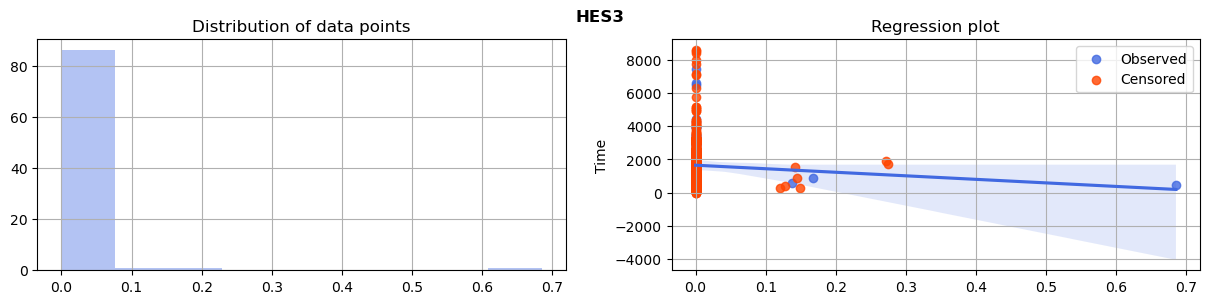

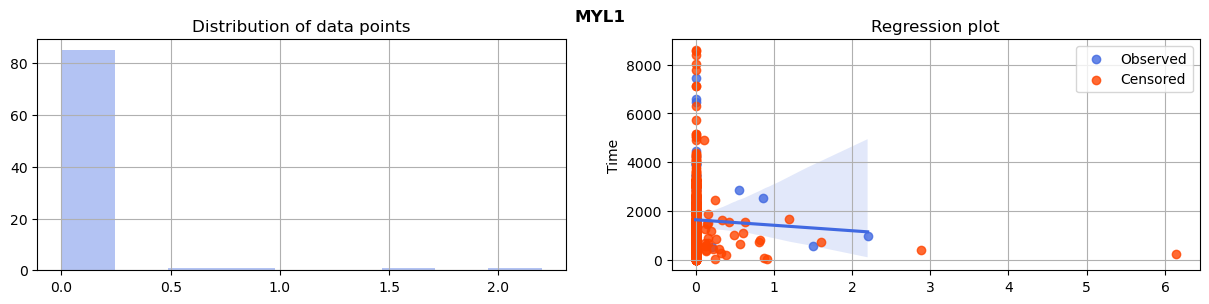

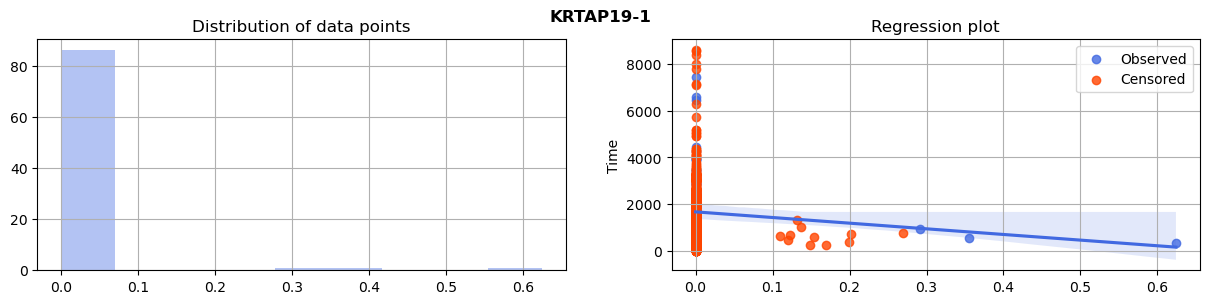

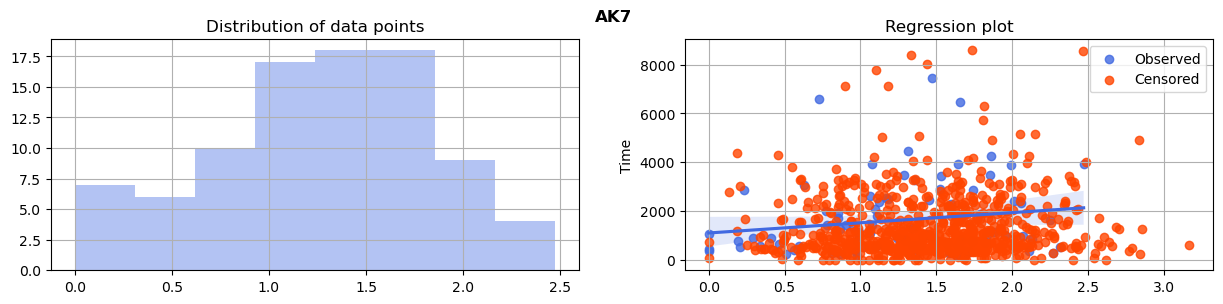

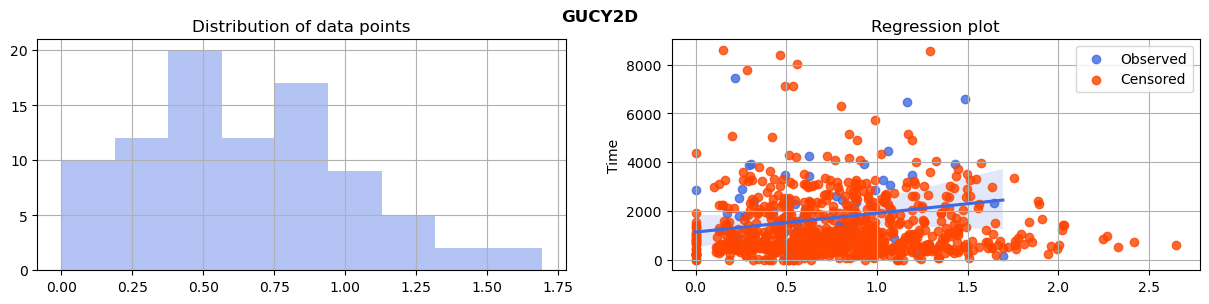

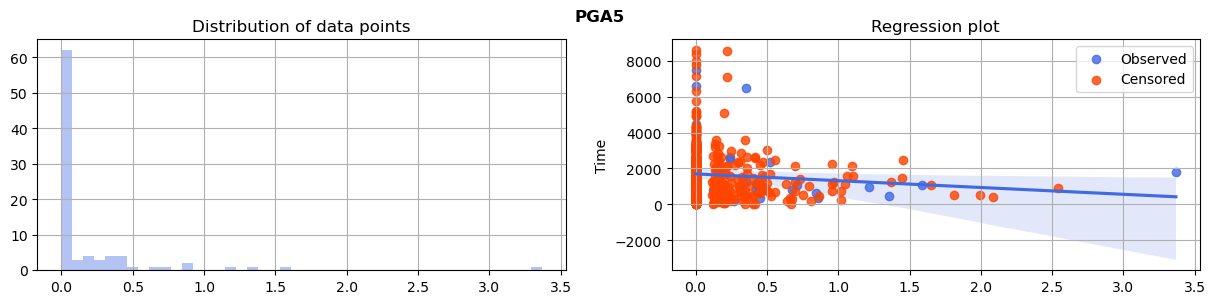

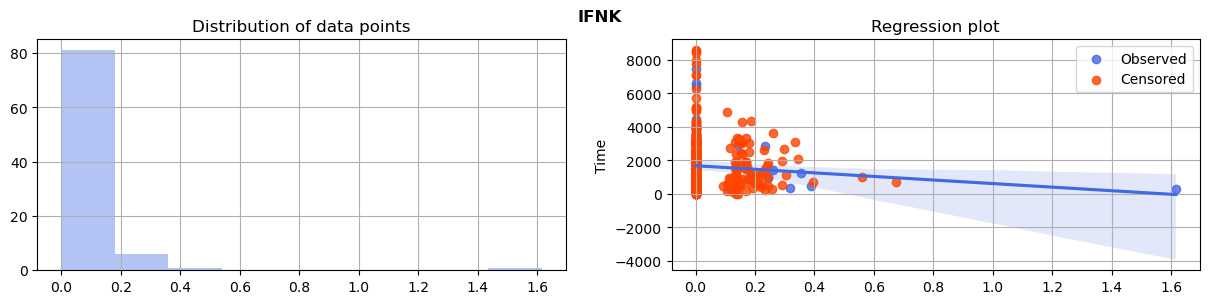

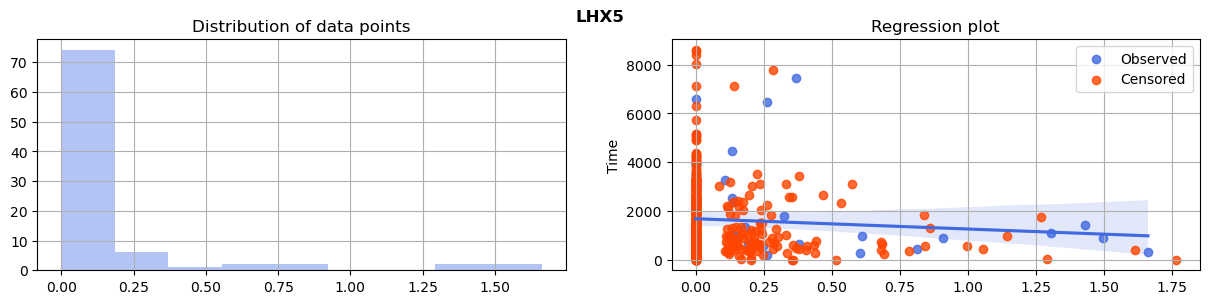

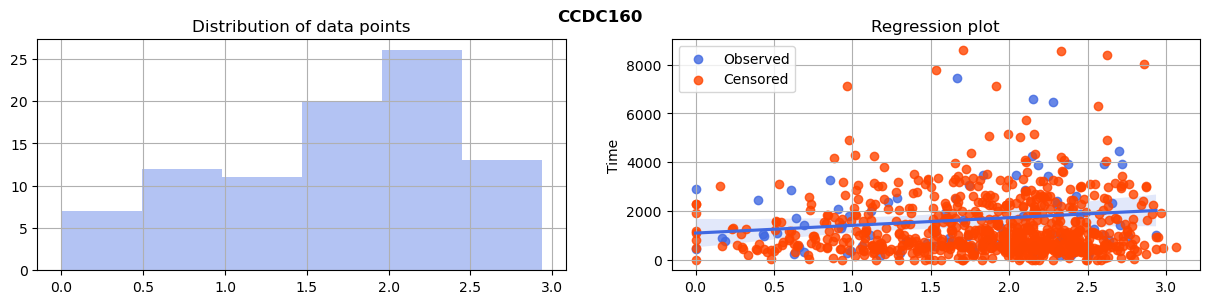

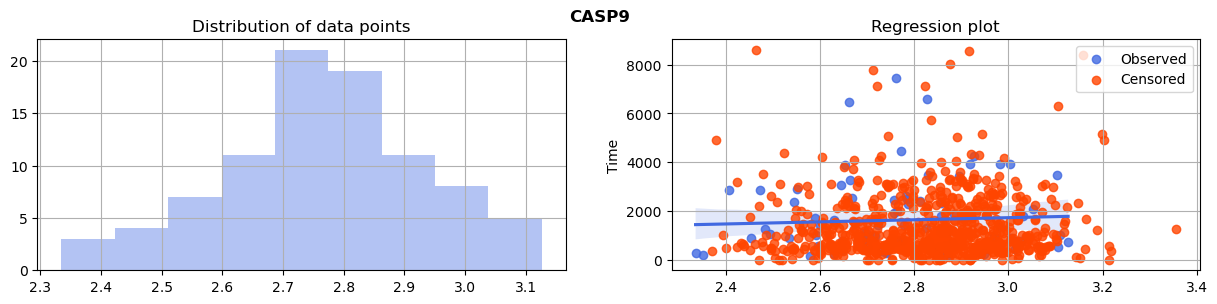

In [51]:
# Visualize the top features of highest -log(p_value)
topNlogp_fnames = screen_stat_res_df.sort_values(by="Nlogp", ascending=False).head(10).Feature.values.tolist()
topNlogp_FeatDF = feats[topNlogp_fnames]
for featureName in topNlogp_FeatDF.columns:
    _, ax = plt.subplots(1, 2, figsize=(15, 3))
    
    # Plot the distribution
    sns.distplot(topNlogp_FeatDF[featureName][surv_inds==1], 
                 kde=False, ax=ax[0], color="royalblue")
    ax[0].grid()
    ax[0].set_title("Distribution of data points")
    ax[0].set_xlabel("")
    
    # Plot the regression line in a scatter plot
    sns.regplot(x=topNlogp_FeatDF[featureName][surv_inds==1], y=surv_times[surv_inds==1], 
                ax=ax[1], color="royalblue", label="Observed")
    sns.regplot(x=topNlogp_FeatDF[featureName][surv_inds==0], y=surv_times[surv_inds==0], 
                ax=ax[1], color="orangered", label="Censored", fit_reg=False)
    ax[1].grid()
    ax[1].set_title("Regression plot")
    ax[1].set_ylabel("Time")
    ax[1].set_xlabel("")
    ax[1].legend()
    
    # Add the title
    plt.suptitle(featureName, weight="semibold")

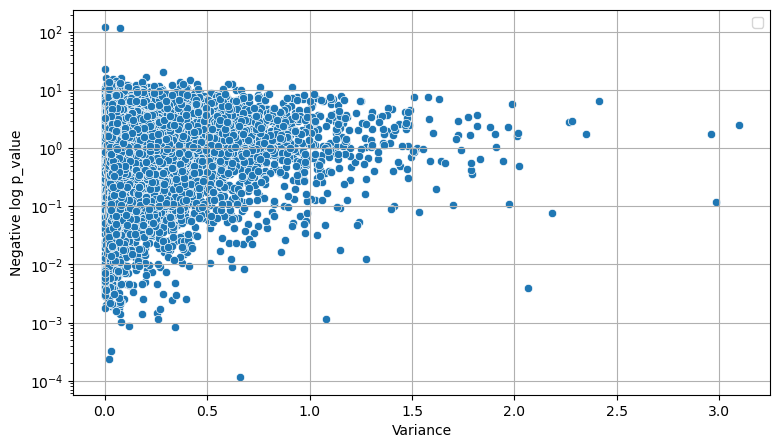

In [61]:
# Visualize the -log(p_value) and variance of feature
_, ax = plt.subplots(figsize=(9, 5))

g_results = sns.scatterplot(screen_stat_res_df, y="Nlogp", x="Var")
g_results.set(yscale='log')
plt.xlabel("Variance")
plt.ylabel("Negative log p_value")
plt.legend()
plt.grid()
plt.show()

***Conclude :*** Low-variance features can still hold significant value, and the majority of features exhibit low variance. Therefore, the screening process relies solely on using −log(p-value) as the criterion.

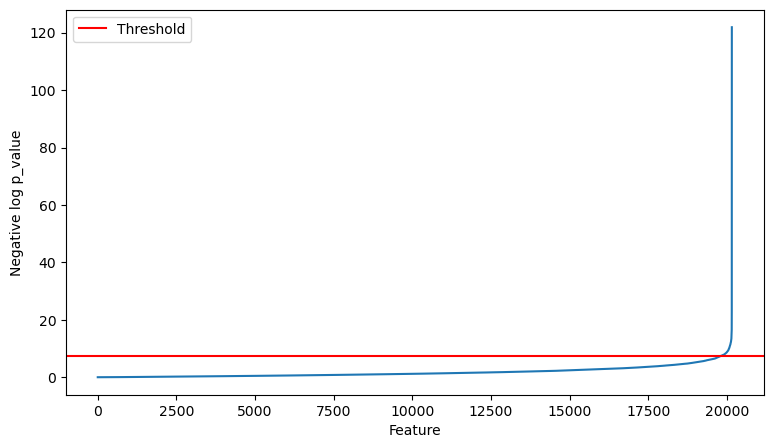

In [66]:
_, ax = plt.subplots(figsize=(9, 5))

screen_pvalues_res_df = pd.DataFrame({"Nlogp" : np.sort(screen_stat_res_df["Nlogp"].values), "idx" :np.arange(screen_stat_res_df.shape[0])})
g_results = sns.lineplot(data=screen_pvalues_res_df, x="idx", y="Nlogp")
# g_results.set(yscale='log')
sel_threshold = 7.5
plt.axhline(y=sel_threshold, c='r', label="Threshold") 
plt.xlabel("Feature")
plt.ylabel("Negative log p_value")
plt.legend()
plt.show()

***Final selection***

In [69]:
numeric_expression_feat_cols = screen_stat_res_df[screen_stat_res_df.Nlogp.values > sel_threshold].Feature.values.tolist()
numeric_non_expression_feat_cols = [col_name for col_name in numeric_feat_cols if col_name in kept_fixed_fnames]
sel_numeric_feat_cols = numeric_non_expression_feat_cols + numeric_expression_feat_cols
sel_feat_cols = [col for col in feat_cols if col in sel_numeric_feat_cols + cate_feat_cols]
sel_feats = feats[sel_feat_cols]

In [71]:
preprocessed_data = sel_feats.copy(deep=True)
preprocessed_data[["surv_time", "surv_indicator"]] = surv_label_df[["surv_time", "surv_indicator"]].values
preprocessed_data.to_csv('preprocessed_data.csv', index=False)

In [73]:
preprocessed_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 840 entries, 14 to 1091
Columns: 340 entries, years_to_birth to surv_indicator
dtypes: float64(336), object(4)
memory usage: 2.2+ MB


In [75]:
print("Number of selected features is {}".format(preprocessed_data.shape[1]))

Number of selected features is 340
